# The Best Format to Save Pandas Data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import os

In [3]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
from utils import Timer, MemoryTracker, GC, NotebookStyle

In [5]:
style = NotebookStyle()
style.override({'grid.color': 'lightgray'})

## Random Dataset

In [6]:
def generate_dataset(n_rows, num_count, cat_count, max_nan=0.1, max_cat_size=100):
    """Randomly generate datasets with numerical and categorical features.
    
    The numerical features are taken from the normal distribution X ~ N(0, 1).
    The categorical features are generated as random uuid4 strings with 
    cardinality C where 2 <= C <= max_cat_size.
    
    Also, a max_nan proportion of both numerical and categorical features is replaces
    with NaN values.
    """
    dataset, types = {}, {}
    
    def generate_categories():
        from uuid import uuid4
        category_size = np.random.randint(2, max_cat_size)
        return [str(uuid4()) for _ in range(category_size)]
    
    for col in range(num_count):
        name = f'n{col}'
        values = np.random.normal(0, 1, n_rows)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'float32'
        
    for col in range(cat_count):
        name = f'c{col}'
        cats = generate_categories()
        values = np.array(np.random.choice(cats, n_rows, replace=True), dtype=object)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'object'
    
    return pd.DataFrame(dataset), types

## Benchmarking

In [7]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [8]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = feather.read_dataframe if fmt == 'feather' else getattr(pd, f'read_{fmt}')
    return save, load

In [9]:
def benchmark(list_of_formats, data_size=1_000_000, n_num=15, n_cat=15, n_rounds=20,
              as_category=False):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        data_size: A number of samples in the generated dataset.
        n_num: A number of numerical columns in the generated dataset.
        n_cat: A number of categorical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
        as_category: If True, then categorical columns will be converted into 
            pandas.Category type before saving.
            
    """
    runs = []
    
    for i in range(n_rounds):
        print(f'Benchmarking round #{i + 1:d}')
        print('\tgenerating dataset...')
        dataset, _ = generate_dataset(data_size, n_num, n_cat)
        
        if as_category:
            print('\tconverting categorical columns into pandas.Category')
            cat_cols = dataset.select_dtypes(include=object).columns
            dataset[cat_cols] = dataset[cat_cols].fillna('none').astype('category')
        
        benchmark = []
        
        for case in list_of_formats:
            fmt, params = case if len(case) == 2 else (case[0], {})
            
            with GC():
                print('\ttesting format:', fmt)
                filename = f'random.{fmt}'
                save, load = get_save_load(dataset, fmt)
                results = defaultdict(int)
                results['format'] = fmt
                results['filename'] = filename
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        save(filename, **params)
                results['size_mb'] = size_of(filename)
                results['save_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['save_time'] = float(timer)
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        _ = load(filename)
                results['load_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                results['load_time'] = float(timer)
                
                benchmark.append(results)
                
            run = pd.DataFrame(benchmark)
            run['run_no'] = i
            runs.append(run)
            
    benchmark = pd.concat(runs, axis=0)
    benchmark.reset_index(inplace=True, drop=True)
    return benchmark

### CSV Baseline

In [27]:
formats = [('csv', {'index': None})]

In [28]:
csv_results = benchmark(formats, n_rounds=5)

Benchmarking round #1
	generating dataset...
	testing format: csv
Benchmarking round #2
	generating dataset...
	testing format: csv
Benchmarking round #3
	generating dataset...
	testing format: csv
Benchmarking round #4
	generating dataset...
	testing format: csv
Benchmarking round #5
	generating dataset...
	testing format: csv


In [29]:
csv_results.to_feather('baseline.feather')

In [51]:
baseline = feather.read_dataframe('baseline.feather')

In [11]:
baseline

,filename,format,load_ram_delta_mb,load_time,save_ram_delta_mb,save_time,size_mb,run_no
0,random.csv,csv,410.468750,7.368307,0.257812,28.585958,775.91,0
1,random.csv,csv,290.539062,7.005593,-1.019531,27.101907,773.68,1
2,random.csv,csv,450.527344,7.006009,-0.023438,27.590825,776.68,2
3,random.csv,csv,381.371094,7.297259,-0.023438,27.487408,764.38,3
4,random.csv,csv,392.964844,7.218375,-0.023438,27.177369,766.56,4


### Categoricals As Strings

In [ ]:
formats = [
    ('hdf', {'key': 'data', 'format': 'table'}),
    ('pickle',),
    ('msgpack',),
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [11]:
results = benchmark(formats)

Benchmarking round #1
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #6
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarki

In [12]:
results.to_feather('one_million_cats_str.feather')

In [52]:
results = feather.read_dataframe('one_million_cats_str.feather')

In [53]:
results = pd.concat([baseline, results], axis=0, sort=False)

In [54]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,load_ram_delta_mb,load_time,save_ram_delta_mb,save_time,size_mb
0,csv,385.174219,7.179108,-0.166406,27.588694,771.4420
1,feather,850.572461,1.333151,635.453125,1.966192,665.0205
2,hdf,2602.573047,9.296356,1337.336523,8.668205,1644.7400
3,msgpack,618.167383,3.164023,1231.050391,4.245394,637.7340
4,parquet,883.852148,0.634647,662.311523,2.439488,129.1415
5,pickle,1211.571289,2.853154,1543.474805,5.329675,651.4410


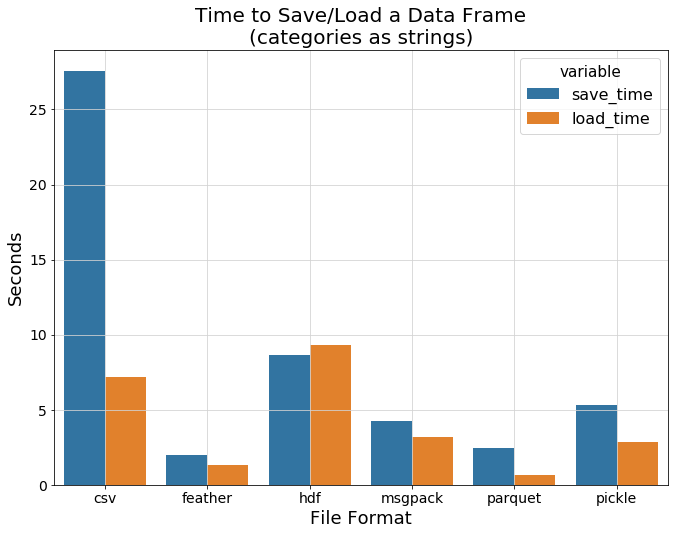

In [55]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as strings)')
ax.grid(True)

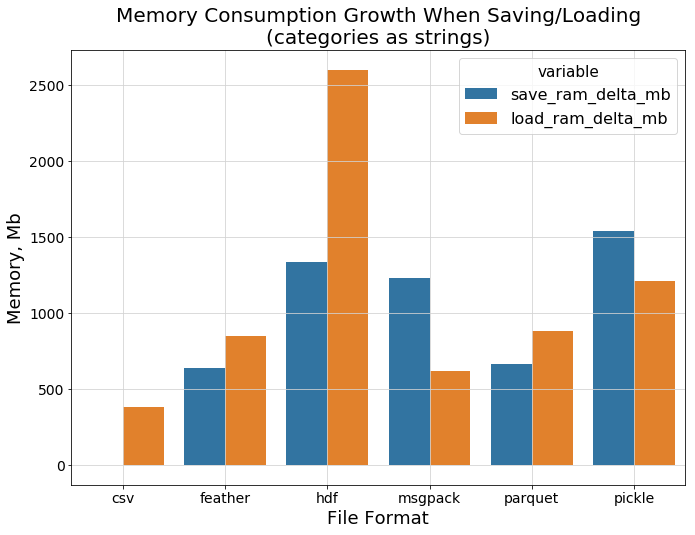

In [56]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as strings)')
ax.grid(True)

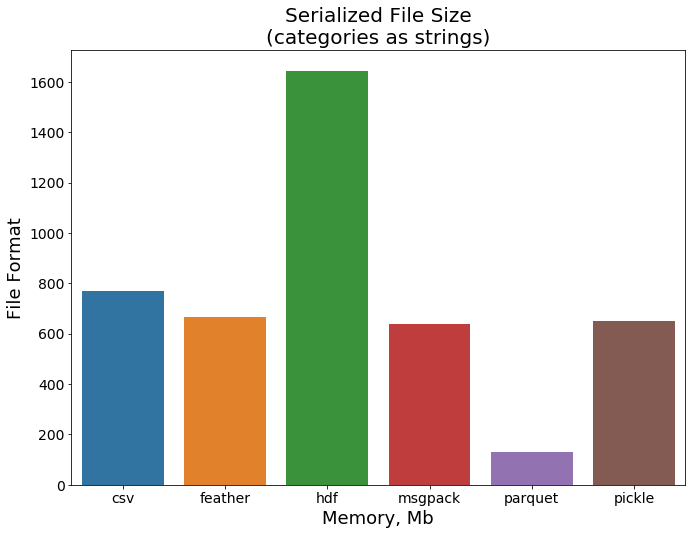

In [57]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as strings)')

### Categoricals As Dedicated Category Type

In [18]:
results = benchmark(formats, as_category=True)

Benchmarking round #1
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing format: pickle
	testing format: msgpack
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	converting categorical columns into pandas.Category
	testing format: hdf
	testing 

In [19]:
results.to_feather('one_million_cats_category.feather')

In [58]:
results  = feather.read_dataframe('one_million_cats_category.feather')

In [59]:
results = pd.concat([baseline, results], axis=0)

In [60]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,load_ram_delta_mb,load_time,save_ram_delta_mb,save_time,size_mb
0,csv,385.174219,7.179108,-0.166406,27.588694,771.4420
1,feather,10.669531,0.044231,0.652148,0.179261,130.5660
2,hdf,327.377148,1.134490,8.731445,0.909780,1269.0565
3,msgpack,195.321094,0.250950,175.532813,0.332355,128.7790
4,parquet,920.664258,0.617414,83.697852,1.936816,128.8640
5,pickle,135.969922,0.118571,198.686523,0.286379,128.7785


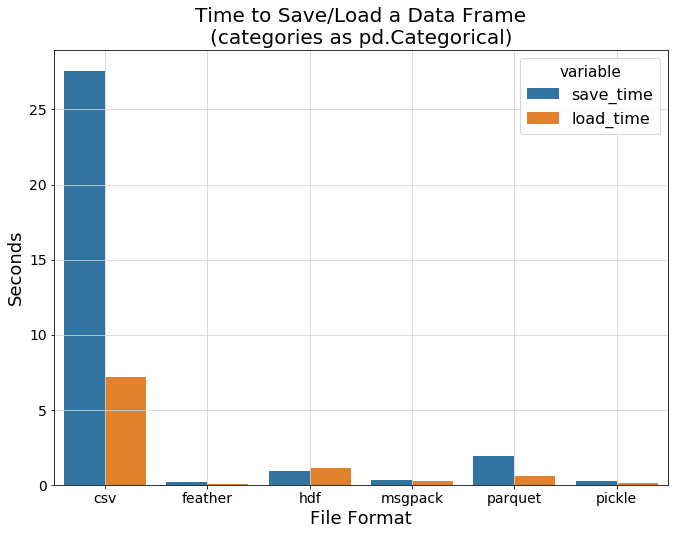

In [61]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

In [62]:
results  = feather.read_dataframe('one_million_cats_category.feather')

In [63]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])

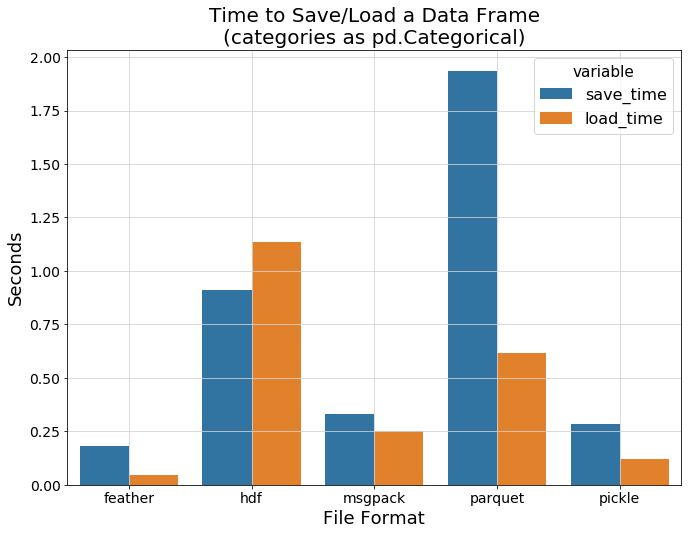

In [64]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as pd.Categorical)')
ax.grid(True)

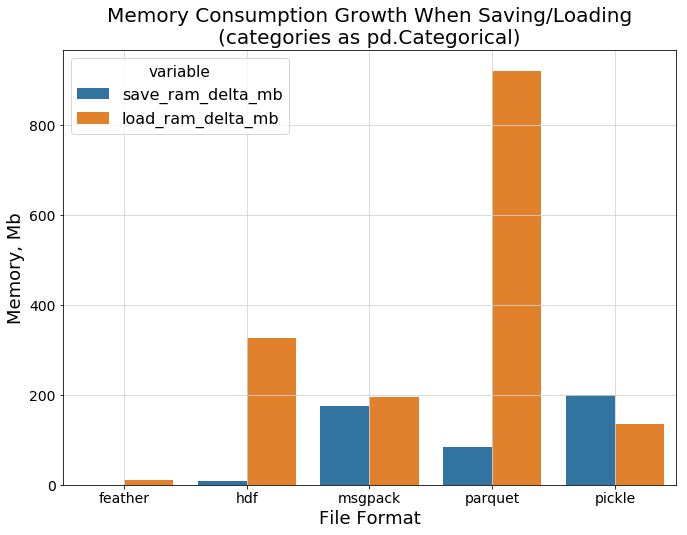

In [65]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as pd.Categorical)')
ax.grid(True)

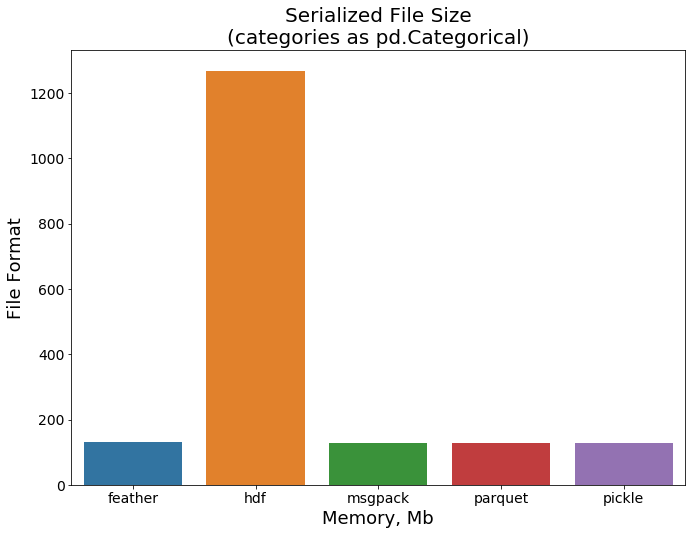

In [66]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as pd.Categorical)')